---
author: Zeel B Patel
badges: true
categories: ML
description: Extreme Image Interpolation with Conditional Neural processes
title: Conditional Neural Processes for Image Interpolation
date: '2023-05-31'
toc: true
---

In [56]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# turn off preallocation by JAX
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import numpy as np
import pandas as pd

from tqdm import tqdm
import jax
import jax.numpy as jnp
import flax.linen as nn

import distrax as dx

import optax

# load mnist dataset from tensorflow datasets
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [57]:
# define initializers
def first_layer_init(key, shape, dtype=jnp.float32):
    num_input = shape[0]  # reverse order compared to torch
    return jax.random.uniform(key, shape, dtype, minval=-1.0/num_input, maxval=1.0/num_input)

def other_layers_init(key, shape, dtype=jnp.float32):
    num_input = shape[0]  # reverse order compared to torch
    return jax.random.uniform(key, shape, dtype, minval=-np.sqrt(6 / num_input)/30, maxval=np.sqrt(6 / num_input)/30)

class Encoder(nn.Module):
  features: list
  encoding_dims: int

  @nn.compact
  def __call__(self, x_context, y_context):
    x = jnp.hstack([x_context, y_context.reshape(x_context.shape[0], -1)])
    
    x = nn.Dense(self.features[0], kernel_init=first_layer_init, bias_init=first_layer_init)(x)
    x = jnp.sin(30*x)
    # x = nn.Dense(self.features[0])(x)
    # x = nn.relu(x)
    
    
    for n_features in self.features[1:]:
      x = nn.Dense(n_features, kernel_init=other_layers_init, bias_init=other_layers_init)(x)
      x = jnp.sin(30*x)
      # x = nn.Dense(n_features)(x)
      # x = nn.relu(x)

    x = nn.Dense(self.encoding_dims)(x)

    representation = x.mean(axis=0, keepdims=True)   # option 1
    return representation  # (1, encoding_dims)

class Decoder(nn.Module):
  features: list
  output_dim: int

  @nn.compact
  def __call__(self, representation, x):
    representation = jnp.repeat(representation, x.shape[0], axis=0)
    x = jnp.hstack([representation, x])
    
    x = nn.Dense(self.features[0], kernel_init=first_layer_init, bias_init=first_layer_init)(x)
    x = jnp.sin(30*x)
    # x = nn.Dense(self.features[0])(x)
    # x = nn.relu(x)

    for n_features in self.features:
      x = nn.Dense(n_features, kernel_init=other_layers_init, bias_init=other_layers_init)(x)
      x = jnp.sin(30*x)
      # x = nn.Dense(n_features)(x)
      # x = nn.relu(x)

    x = nn.Dense(self.output_dim*2)(x)
    loc, raw_scale = x[:, :self.output_dim], x[:, self.output_dim:]
    scale = jnp.exp(raw_scale)
    
    return loc, scale

class CNP(nn.Module):
  encoder_features: list
  encoding_dims: int
  decoder_features: list
  output_dim: int

  @nn.compact
  def __call__(self, x_content, y_context, x_target):
    representation = Encoder(self.encoder_features, self.encoding_dims)(x_content, y_context)
    loc, scale = Decoder(self.decoder_features, self.output_dim)(representation, x_target)
    return loc, scale

  def loss_fn(self, params, x_context, y_context, x_target, y_target):
    loc, scale = self.apply(params, x_context, y_context, x_target)
    predictive_distribution = dx.MultivariateNormalDiag(loc=loc, scale_diag=0.005+scale)
    return -predictive_distribution.log_prob(y_target)

## Load MNIST

In [58]:
ds = tfds.load('mnist')

In [59]:
def dataset_to_arrays(dataset):
    data = []
    labels = []
    stopper = 0
    end = 100
    for sample in dataset:
        data.append(sample["image"].numpy())
        labels.append(sample["label"].numpy())
        stopper += 1
        if stopper == end:
            break
    return np.array(data), np.array(labels)[..., None]

train_data, train_labels = dataset_to_arrays(ds["train"])
test_data, test_labels = dataset_to_arrays(ds["test"])

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

2023-06-02 09:58:48.609001: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-02 09:58:48.681190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


((100, 28, 28, 1), (100, 1), (100, 28, 28, 1), (100, 1))

In [60]:
coords = np.linspace(-1, 1, 28)
x, y = np.meshgrid(coords, coords)
train_X = jnp.stack([x, y], axis=-1).reshape(-1, 2)

train_y = jax.vmap(lambda x: x.reshape(-1, 1))(train_data) / 255.0
train_X.shape, train_y.shape, type(train_X), type(train_y)

((784, 2),
 (100, 784, 1),
 jaxlib.xla_extension.ArrayImpl,
 jaxlib.xla_extension.ArrayImpl)

In [61]:
iterations = 10000

def loss_fn(params, context_X, context_y, target_X, target_y):
  def loss_fn_per_sample(context_X, context_y, target_X, target_y):
    loc, scale = model.apply(params, context_X, context_y, target_X)
    # predictive_distribution = dx.MultivariateNormalDiag(loc=loc, scale_diag=scale)
    # return -predictive_distribution.log_prob(target_y)
    return jnp.square(loc.ravel() - target_y.ravel()).mean()
  
  return jax.vmap(loss_fn_per_sample, in_axes=(None, 0, None, 0))(context_X, context_y, target_X, target_y).mean()

value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
model = CNP([256]*2, 128, [256]*4, 1)
params = model.init(jax.random.PRNGKey(0), train_X, train_y[0], train_X)
optimizer = optax.adam(1e-5)
state = optimizer.init(params)

# losses = []
# for iter in tqdm(range(iterations)):
#   tmp_index = jax.random.permutation(jax.random.PRNGKey(iter), index)
#   context_X = train_X[tmp_index][:int(train_X.shape[0]*0.05)]
#   context_y = train_y[:, tmp_index, :][:, :int(train_X.shape[0]*0.05), :]
#   target_X = train_X[tmp_index][int(train_X.shape[0]*0.05):]
#   target_y = train_y[:, tmp_index, :][:, int(train_X.shape[0]*0.05):, :]
  
#   # print(context_X.shape, context_y.shape, target_X.shape, target_y.shape)
#   # print(loss_fn(params, context_X, context_y, target_X, target_y).shape)
  
#   loss, grads = value_and_grad_fn(params, context_X, context_y, target_X, target_y)
#   updates, state = optimizer.update(grads, state)
#   params = optax.apply_updates(params, updates)
#   losses.append(loss.item())

def one_step(params_and_state, key):
  params, state = params_and_state
  tmp_index = jax.random.permutation(key, train_X.shape[0])
  context_X = train_X[tmp_index][:int(train_X.shape[0]*0.05)]
  context_y = train_y[:, tmp_index, :][:, :int(train_X.shape[0]*0.05), :]
  target_X = train_X[tmp_index][int(train_X.shape[0]*0.05):]
  target_y = train_y[:, tmp_index, :][:, int(train_X.shape[0]*0.05):, :]
  loss, grads = value_and_grad_fn(params, context_X, context_y, target_X, target_y)
  updates, state = optimizer.update(grads, state)
  params = optax.apply_updates(params, updates)
  return (params, state), loss

(params, state), loss_history = jax.lax.scan(one_step, (params, state), jax.random.split(jax.random.PRNGKey(0), iterations))

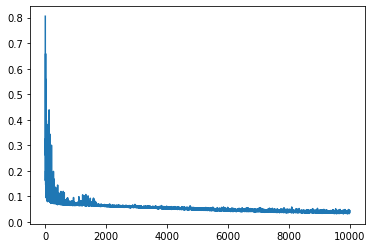

In [62]:
plt.plot(loss_history[10:]);

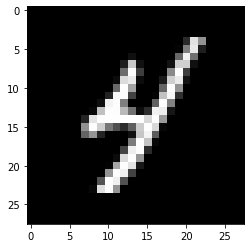

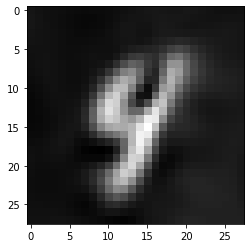

In [63]:
test_key = jax.random.PRNGKey(0)
tmp_index = jax.random.permutation(test_key, train_X.shape[0])
context_X = train_X[tmp_index][:int(train_X.shape[0]*0.5)]
context_y = train_y[:, tmp_index, :][:, :int(train_X.shape[0]*0.5), :]
target_X = train_X#[tmp_index][int(train_X.shape[0]*0.5):]
target_y = train_y#[:, tmp_index, :][:, int(train_X.shape[0]*0.5):, :]

id = 91
plt.imshow(train_y[id].reshape(28, 28), cmap="gray", interpolation=None);

locs, scales = jax.vmap(model.apply, in_axes=(None, None, 0, None))(params, context_X, context_y, target_X)
# full_preds = jnp.concatenate([context_y, locs], axis=1)
# full_preds = full_preds.at[:, tmp_index, :].set(full_preds).__array__()

plt.figure()
plt.imshow(locs[id].reshape(28, 28), cmap="gray", interpolation=None);